<a href="https://colab.research.google.com/github/pengyk/COMP551/blob/main/Copy_of_Copy_of_mini_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import datetime 
import math
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Normalizatin data with means / median

In [3]:
def de_mean_trends(df, standard=False):
  for column in df.columns:
    if column.startswith('symptom:'):
      df[column] = df[column] - df[column].median()
      if standard:
        df[column] = df[column]/df[column].std()

def de_median_trends(df):
  for column in df.columns:
    if column.startswith('symptom:'):
      df[column] = df[column] - df[column].median()


# Function to plot distribution of search frequencies across time

In [4]:
def plot_data(symptoms_df, complete_df):
  
  # iterate through the region
  for index, row in symptoms_df.iterrows():
    region = symptoms_df.open_covid_region_code[index]
    region_df = complete_df.loc[complete_df['open_covid_region_code'] == region]
    region_df = region_df.reset_index(drop = True)
    n_weeks = len(region_df)
    X = np.zeros([4, n_weeks])
    f, ax = plt.subplots(1, 1)

    # days = [d.date() for d in region_df['date'].tolist()]
    # print(days)

    # iterate through the symptoms
    for i in range(4):
      # the symptom is actually offset by 1 in the column because of the first column, region code
      # check for each symptom out of top 4 symptom searched
      symptom = row.iloc[i + 1]
      # iterate through the weeks
      for j, region_row in region_df.iterrows():
        X[i, j] = region_row[symptom]
      sns.regplot(x = list(range(0, n_weeks)),y = X[i], lowess=True, label=symptom).set_title("Region: " + region)
    ax.legend()
    plt.show()
    # return


# Clean data (drop all rows / columns with more than 5% of NaN values)

In [5]:
def clean_data(df):
  (rows, cols) = df.shape
  row_threshold = int(rows * 0.05)
  col_threshold = int(cols * 0.05)

# remove row if too many columns are nan and vice versa
  df = df.dropna(axis = 0, thresh = col_threshold)
  df = df.dropna(axis = 1, thresh = row_threshold)
  df = df.reset_index(drop = True)
  (rows, cols) = df.shape
  return df


# K-Means

In [6]:
def classify_KMeans(complete_df):
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)
  X = complete_df[complete_df.columns[pd.Series(complete_df.columns).str.startswith('symptom')]]

  range_n_clusters = list(range(5, 50))

  best_average = 0
  best_K = 0

  for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    if silhouette_avg > best_average:
      best_average = silhouette_avg
      best_k = n_clusters
  
  print("best number of clusters is: ", best_k)
  kmeans = KMeans(n_clusters=best_k)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  X = TSNE(n_components=2).fit_transform(X)
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)
  centers = kmeans.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
  plt.show()

# Decision Tree Regressor

In [7]:
def decisionTree_regressor_test(complete_df, split_type):
    
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train[train.columns[pd.Series(train.columns).str.startswith('symptom')]]
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    print(test[column].unique())
    print(train[column].unique())
    X_test = test[test.columns[pd.Series(test.columns).str.startswith('symptom')]]
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']

    error_rate = []
    for i in range(1,40):
      dt = DecisionTreeRegressor(max_depth = i)
      dt.fit(X_train,Y_train)
      pred_i = dt.predict(X_test)
      error_rate.append(np.mean((pred_i - Y_test)**2))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title("By Date: Validation on " + (','.join(test_list)))
    else:
      start = pd.to_datetime(test_list[0])
      end = pd.to_datetime(test_list[-1])
      plt.title('By Date ' + str(start.date()) +  ' to ' + str(end.date()))    
    plt.xlabel('Depth')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at depth level =",error_rate.index(min(error_rate)))

In [8]:
def decisionTree_classifier_correct(complete_df, split_type):
  
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    X = complete_df[complete_df.columns[pd.Series(complete_df.columns).str.startswith('symptom')]]
    y = complete_df[['hospitalized_new']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    error_rate = []
    for i in range(5,101):
      if i % 2 == 0:
        continue
      dt = DecisionTreeRegressor(max_depth=i)
      cv_scores = cross_val_score(dt, X, y, cv=5, scoring='neg_mean_squared_error')
      error_rate.append((np.mean(cv_scores)))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,49),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title("By Date")
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate))+2)

  else:
    d_day = datetime.datetime(2020, 8, 10) 
    # one split
    train = complete_df[complete_df['date'] < (d_day)]
    test = complete_df[complete_df['date'] >= (d_day)]

    X_train = train[train.columns[pd.Series(train.columns).str.startswith('symptom')]]
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    X_test = test[test.columns[pd.Series(test.columns).str.startswith('symptom')]]
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']

    error_rate = []
    for i in range(1,99):
      dt = DecisionTreeRegressor(max_depth = i)
      dt.fit(X_train,Y_train)
      pred_i = dt.predict(X_test)
      error_rate.append(mean_squared_error(Y_test, pred_i))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,99),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title('By Date ')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

# KNN Regressor

In [9]:
def knn_classifier_test(complete_df, split_type):
  
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train[train.columns[pd.Series(train.columns).str.startswith('symptom')]]
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    print(test[column].unique())
    print(train[column].unique())
    X_test = test[test.columns[pd.Series(test.columns).str.startswith('symptom')]]
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']


    # k = 10
    # neighbhoor = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
    # Pred_y = neighbhoor.predict(X_test)
    # print("Accuracy of model at K=4 is",metrics.accuracy_score(Y_test, Pred_y))
    error_rate = []
    for i in range(1,41):
      if i % 2 == 0:
        continue
      knn = KNeighborsRegressor(n_neighbors=i)
      knn.fit(X_train,Y_train)
      pred_i = knn.predict(X_test)
      error_rate.append(np.mean((pred_i - Y_test)**2))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,21),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title("By Date: Validation on " + (','.join(test_list)))
    else:
      start = pd.to_datetime(test_list[0])
      end = pd.to_datetime(test_list[-1])
      plt.title('By Date ' + str(start.date()) +  ' to ' + str(end.date()))
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate)))


In [10]:
def knn_classifier_correct(complete_df, split_type):
  
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    X = complete_df[complete_df.columns[pd.Series(complete_df.columns).str.startswith('symptom')]]
    y = complete_df[['hospitalized_new']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    error_rate = []
    for i in range(5,101):
      if i % 2 == 0:
        continue
      knn = KNeighborsRegressor(n_neighbors=i)
      cv_scores = cross_val_score(knn, X, y, cv=5, scoring='neg_mean_squared_error')
      error_rate.append((np.mean(cv_scores)))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,49),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title("By Date")
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate))*2 +5)

  else:
    d_day = datetime.datetime(2020, 8, 10) 
    # one split
    train = complete_df[complete_df['date'] < (d_day)]
    test = complete_df[complete_df['date'] >= (d_day)]

    X_train = train[train.columns[pd.Series(train.columns).str.startswith('symptom')]]
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    X_test = test[test.columns[pd.Series(test.columns).str.startswith('symptom')]]
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']

    # k = 10
    # neighbhoor = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
    # Pred_y = neighbhoor.predict(X_test)
    # print("Accuracy of model at K=4 is",metrics.accuracy_score(Y_test, Pred_y))
    error_rate = []
    for i in range(5,201):
      knn = KNeighborsRegressor(n_neighbors=i)
      knn.fit(X_train,Y_train)
      pred_i = knn.predict(X_test)
      error_rate.append(mean_squared_error(Y_test, pred_i))

    plt.figure(figsize=(10,6))
    plt.plot(range(5,201),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    plt.title('By Date ')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate))+5)


# Main

In [11]:
cases_df = pd.read_csv("drive/My Drive/COMP551/assignment1/aggregated_cc_by.csv")
trends_df = pd.read_csv("drive/My Drive/COMP551/assignment1//2020_US_weekly_symptoms_dataset.csv")
trends_df.head()
# _____________________________________________Experimentation with daily dataset (keeping all symptoms)________________
# daily_trends_df = pd.read_csv("drive/My Drive/COMP551/assignment1//2020_US_daily_symptoms_dataset.csv")
# daily_trends_df['date']=daily_trends_df['date'].astype('datetime64[ns]')
# daily_to_weekly_trends_df = daily_trends_df.groupby(['open_covid_region_code']).resample('W', on= "date").sum()
# trends_df = daily_to_weekly_trends_df
# trends_df = trends_df.reset_index()
# trends_df.head()

# _____________________________________________Experimentation with daily dataset (only keeping symptoms of COVID19)________________
# daily_trends_df = pd.read_csv("drive/My Drive/COMP551/assignment1//2020_US_daily_symptoms_dataset.csv")
# daily_trends_df['date']=daily_trends_df['date'].astype('datetime64[ns]')
# daily_to_weekly_trends_df = daily_trends_df.groupby(['open_covid_region_code']).resample('W', on= "date").sum()
# trends_df = daily_to_weekly_trends_df
# trends_df = trends_df.reset_index()
# trends_df = trends_df[['open_covid_region_code', 'date', 'symptom:Fever', 'symptom:Cough', 'symptom:Fatigue', 'symptom:Sore throat', 'symptom:Headache', 'symptom:Conjunctivitis', 'symptom:Shortness of breath', 'symptom:Chest pain', 'symptom:Skin rash']]
# print(trends_df)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Throat irritation,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,12.69,NaN,NaN,NaN,NaN,NaN,12.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.31,NaN,NaN,NaN,...,NaN,NaN,15.86,NaN,NaN,NaN,NaN,NaN,11.90,NaN,NaN,NaN,NaN,18.84,13.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.08,9.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.28,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,9.56,NaN,NaN,NaN,NaN,NaN,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.20,NaN,NaN,NaN,...,NaN,NaN,12.24,NaN,NaN,NaN,NaN,NaN,7.84,NaN,NaN,NaN,NaN,16.83,13.01,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,15.30,8.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.26,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.90,NaN,NaN,NaN,...,NaN,NaN,17.66,NaN,NaN,NaN,NaN,NaN,15.27,NaN,NaN,NaN,NaN,18.40,12.14,NaN,NaN,7.54,NaN,NaN,NaN,NaN,NaN,10.30,16.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.48,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-27,NaN,NaN,NaN,NaN,NaN,15.31,7.47,NaN,NaN,NaN,NaN,15.67,NaN,NaN,NaN,NaN,NaN,NaN,7.47,NaN,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,12.03,NaN,NaN,NaN,...,NaN,NaN,12.76,NaN,NaN,NaN,NaN,NaN,9.84,NaN,NaN,NaN,NaN,20.41,17.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.93,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-03,NaN,NaN,NaN,NaN,NaN,8.81,NaN,NaN,NaN,NaN,NaN,13.87,NaN,NaN,NaN,NaN,NaN,NaN,8.06,NaN,NaN,NaN,12.56,NaN,NaN,NaN,NaN,NaN,14.24,NaN,NaN,NaN,...,NaN,NaN,16.68,NaN,NaN,NaN,NaN,NaN,10.68,NaN,NaN,NaN,NaN,20.62,16.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.24,10.68,NaN,NaN,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.93,NaN,NaN


In [12]:
us_states = trends_df.open_covid_region_code.unique()
us_cases = cases_df[cases_df['open_covid_region_code'].isin(us_states)]
us_cases = us_cases.reset_index(drop = True)
us_cases = us_cases[['open_covid_region_code', 'region_name', 'date', 'hospitalized_new']]
print(us_cases)

us_cases.open_covid_region_code.unique()

     open_covid_region_code region_name        date  hospitalized_new
0                     US-WY     Wyoming  2020-03-07               0.0
1                     US-WY     Wyoming  2020-03-08               0.0
2                     US-WY     Wyoming  2020-03-09               0.0
3                     US-WY     Wyoming  2020-03-10               0.0
4                     US-WY     Wyoming  2020-03-11               0.0
...                     ...         ...         ...               ...
3357                  US-AK      Alaska  2020-09-27               0.0
3358                  US-AK      Alaska  2020-09-28               0.0
3359                  US-AK      Alaska  2020-09-29               0.0
3360                  US-AK      Alaska  2020-09-30               0.0
3361                  US-AK      Alaska  2020-10-01               0.0

[3362 rows x 4 columns]


array(['US-WY', 'US-WV', 'US-VT', 'US-SD', 'US-RI', 'US-NM', 'US-NH',
       'US-NE', 'US-ND', 'US-MT', 'US-ME', 'US-ID', 'US-HI', 'US-DE',
       'US-DC', 'US-AK'], dtype=object)

In [13]:
us_cases = us_cases[['open_covid_region_code', 'date', 'hospitalized_new']]
us_cases.head()
print(us_cases)

     open_covid_region_code        date  hospitalized_new
0                     US-WY  2020-03-07               0.0
1                     US-WY  2020-03-08               0.0
2                     US-WY  2020-03-09               0.0
3                     US-WY  2020-03-10               0.0
4                     US-WY  2020-03-11               0.0
...                     ...         ...               ...
3357                  US-AK  2020-09-27               0.0
3358                  US-AK  2020-09-28               0.0
3359                  US-AK  2020-09-29               0.0
3360                  US-AK  2020-09-30               0.0
3361                  US-AK  2020-10-01               0.0

[3362 rows x 3 columns]


In [14]:
print("Before cleaning:")
print(trends_df.shape)

trends_df = clean_data(trends_df)

print("After cleaning:")
print(trends_df.shape)
de_median_trends(trends_df)


Before cleaning:
(608, 430)
After cleaning:
(418, 127)


In [15]:
trends_df['date'] = pd.to_datetime(trends_df['date'])
trends_df['date']=trends_df['date'].astype('datetime64[ns]')
us_cases['date'] = us_cases['date'].astype('datetime64[ns]')
complete_df = trends_df.merge(us_cases, how='inner', on=['open_covid_region_code', 'date'])
complete_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amblyopia,symptom:Amenorrhea,symptom:Angular cheilitis,symptom:Anosmia,symptom:Aphonia,symptom:Ascites,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Bleeding on probing,symptom:Burning Chest Pain,symptom:Burning mouth syndrome,symptom:Cataplexy,symptom:Chancre,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Compulsive hoarding,symptom:Crackles,symptom:Crepitus,symptom:Croup,symptom:Cyanosis,symptom:Depersonalization,symptom:Developmental disability,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dystonia,symptom:Dysuria,...,symptom:Papule,symptom:Paranoia,symptom:Pericarditis,symptom:Petechia,symptom:Photodermatitis,symptom:Photophobia,symptom:Photopsia,symptom:Pleurisy,symptom:Polycythemia,symptom:Polydipsia,symptom:Polyuria,symptom:Postural orthostatic tachycardia syndrome,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Renal colic,symptom:Rheum,symptom:Round ligament pain,symptom:Rumination,symptom:Sensitivity to sound,symptom:Shallow breathing,symptom:Spasticity,symptom:Splenomegaly,symptom:Sputum,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Viral pneumonia,symptom:Yawn,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-03-09,-0.19,NaN,3.58,NaN,1.99,NaN,-2.66,-0.255,NaN,1.89,3.34,NaN,4.12,3.21,-0.04,NaN,0.335,2.88,4.79,-3.715,2.09,NaN,NaN,NaN,NaN,21.55,-0.83,NaN,NaN,0.45,-2.15,-0.02,0.00,2.665,...,0.50,5.06,NaN,7.01,NaN,0.97,4.71,NaN,3.37,NaN,-0.97,NaN,2.16,-1.155,-1.255,0.41,5.15,4.77,0.35,-1.18,1.26,0.565,NaN,0.845,11.645,NaN,3.87,13.615,0.77,1.80,-0.01,4.23,36.01,0.15,NaN,2.51,NaN,7.95,2.06,0.0
1,US-AK,US,United States,Alaska,US-AK,2020-03-16,0.90,NaN,-1.64,NaN,NaN,NaN,5.86,-0.215,NaN,-0.84,1.22,NaN,-2.05,-0.11,1.29,1.90,-2.355,-1.21,4.36,-3.125,-2.69,NaN,NaN,-0.325,NaN,35.22,0.88,-0.84,-3.85,-0.58,-1.52,3.81,-3.78,0.695,...,-3.69,3.07,-1.49,NaN,NaN,-0.81,6.58,NaN,2.36,NaN,-2.58,NaN,NaN,0.315,-0.995,-0.80,2.68,2.53,-0.40,2.09,NaN,3.395,-1.025,-2.225,17.605,1.39,2.84,-1.565,-0.46,0.06,3.37,-0.70,67.77,1.88,NaN,4.78,NaN,14.04,5.63,0.0
2,US-AK,US,United States,Alaska,US-AK,2020-03-23,0.36,8.175,NaN,NaN,-1.27,NaN,35.44,NaN,NaN,-2.52,0.81,-2.19,-1.90,1.07,0.22,6.47,-2.125,1.03,0.95,3.355,-1.19,NaN,NaN,-0.535,NaN,24.18,-0.61,NaN,-6.92,-2.12,5.59,-1.51,-1.98,1.005,...,1.25,5.41,4.66,3.34,NaN,1.08,4.23,NaN,1.73,NaN,-0.97,NaN,-1.32,-0.515,-2.015,-1.46,3.00,2.31,0.39,1.68,2.14,1.725,0.555,0.485,18.545,-1.10,0.75,-0.475,2.22,-0.75,-3.49,-1.38,26.60,-1.32,NaN,0.00,-1.63,2.89,6.98,0.0
3,US-AK,US,United States,Alaska,US-AK,2020-03-30,-1.83,0.565,-0.92,NaN,-2.27,NaN,9.32,NaN,NaN,0.03,-3.09,-2.10,-0.92,2.43,-1.35,0.92,-0.535,1.96,3.63,-0.975,-2.09,-2.66,NaN,NaN,NaN,12.39,1.54,1.33,-8.62,NaN,3.39,-2.03,NaN,-2.505,...,-0.01,7.73,0.97,3.74,NaN,0.08,4.35,NaN,0.15,1.03,NaN,NaN,-2.12,1.655,NaN,-2.06,2.77,NaN,0.72,-0.66,-1.62,3.295,NaN,-3.285,13.245,-2.03,2.41,-3.475,3.28,-1.21,-1.74,5.05,13.52,-0.31,0.17,0.79,-1.56,-2.08,8.92,1.0
4,US-AK,US,United States,Alaska,US-AK,2020-04-06,-0.71,-1.045,NaN,NaN,0.00,-0.76,-2.96,NaN,NaN,-2.26,0.89,NaN,-1.07,-0.43,3.65,-0.41,-1.555,NaN,0.11,3.215,-1.96,NaN,NaN,-1.695,NaN,3.21,3.12,-1.42,-7.94,NaN,0.98,-1.21,-4.06,1.355,...,-5.47,2.88,-0.20,-1.68,NaN,1.06,8.08,NaN,4.44,-0.89,-4.30,NaN,0.99,0.635,2.045,-1.35,1.34,-0.48,-0.41,-0.69,-1.52,-0.455,-1.775,-1.025,5.925,1.80,NaN,-1.945,-0.01,-1.94,-2.48,4.09,5.34,-0.04,NaN,4.34,NaN,-1.83,5.41,3.0


In [16]:
avgdf = complete_df.groupby(['open_covid_region_code']).mean()
only_symptoms_df = avgdf.drop(['hospitalized_new'], axis = 1)
only_symptoms_df = pd.DataFrame(only_symptoms_df.columns.values[np.argsort(-only_symptoms_df.values, axis=1)[:, :4]], index=only_symptoms_df.index, columns = ['1st Max','2nd Max','3rd Max', '4th Max']).reset_index()

only_symptoms_df.head()

,open_covid_region_code,1st Max,2nd Max,3rd Max,4th Max
0,US-AK,symptom:Photopsia,symptom:Chancre,symptom:Paranoia,symptom:Yawn
1,US-DC,symptom:Ageusia,symptom:Rumination,symptom:Shallow breathing,symptom:Gingival recession
2,US-DE,symptom:Photodermatitis,symptom:Anosmia,symptom:Ageusia,symptom:Stomach rumble
3,US-ME,symptom:Dysautonomia,symptom:Shallow breathing,symptom:Myoclonus,symptom:Rectal pain
4,US-MT,symptom:Photodermatitis,symptom:Anosmia,symptom:Asphyxia,symptom:Subdural hematoma


In [17]:
complete_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amblyopia,symptom:Amenorrhea,symptom:Angular cheilitis,symptom:Anosmia,symptom:Aphonia,symptom:Ascites,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Bleeding on probing,symptom:Burning Chest Pain,symptom:Burning mouth syndrome,symptom:Cataplexy,symptom:Chancre,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Compulsive hoarding,symptom:Crackles,symptom:Crepitus,symptom:Croup,symptom:Cyanosis,symptom:Depersonalization,symptom:Developmental disability,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dystonia,symptom:Dysuria,...,symptom:Papule,symptom:Paranoia,symptom:Pericarditis,symptom:Petechia,symptom:Photodermatitis,symptom:Photophobia,symptom:Photopsia,symptom:Pleurisy,symptom:Polycythemia,symptom:Polydipsia,symptom:Polyuria,symptom:Postural orthostatic tachycardia syndrome,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Renal colic,symptom:Rheum,symptom:Round ligament pain,symptom:Rumination,symptom:Sensitivity to sound,symptom:Shallow breathing,symptom:Spasticity,symptom:Splenomegaly,symptom:Sputum,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Viral pneumonia,symptom:Yawn,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-03-09,-0.19,NaN,3.58,NaN,1.99,NaN,-2.66,-0.255,NaN,1.89,3.34,NaN,4.12,3.21,-0.04,NaN,0.335,2.88,4.79,-3.715,2.09,NaN,NaN,NaN,NaN,21.55,-0.83,NaN,NaN,0.45,-2.15,-0.02,0.00,2.665,...,0.50,5.06,NaN,7.01,NaN,0.97,4.71,NaN,3.37,NaN,-0.97,NaN,2.16,-1.155,-1.255,0.41,5.15,4.77,0.35,-1.18,1.26,0.565,NaN,0.845,11.645,NaN,3.87,13.615,0.77,1.80,-0.01,4.23,36.01,0.15,NaN,2.51,NaN,7.95,2.06,0.0
1,US-AK,US,United States,Alaska,US-AK,2020-03-16,0.90,NaN,-1.64,NaN,NaN,NaN,5.86,-0.215,NaN,-0.84,1.22,NaN,-2.05,-0.11,1.29,1.90,-2.355,-1.21,4.36,-3.125,-2.69,NaN,NaN,-0.325,NaN,35.22,0.88,-0.84,-3.85,-0.58,-1.52,3.81,-3.78,0.695,...,-3.69,3.07,-1.49,NaN,NaN,-0.81,6.58,NaN,2.36,NaN,-2.58,NaN,NaN,0.315,-0.995,-0.80,2.68,2.53,-0.40,2.09,NaN,3.395,-1.025,-2.225,17.605,1.39,2.84,-1.565,-0.46,0.06,3.37,-0.70,67.77,1.88,NaN,4.78,NaN,14.04,5.63,0.0
2,US-AK,US,United States,Alaska,US-AK,2020-03-23,0.36,8.175,NaN,NaN,-1.27,NaN,35.44,NaN,NaN,-2.52,0.81,-2.19,-1.90,1.07,0.22,6.47,-2.125,1.03,0.95,3.355,-1.19,NaN,NaN,-0.535,NaN,24.18,-0.61,NaN,-6.92,-2.12,5.59,-1.51,-1.98,1.005,...,1.25,5.41,4.66,3.34,NaN,1.08,4.23,NaN,1.73,NaN,-0.97,NaN,-1.32,-0.515,-2.015,-1.46,3.00,2.31,0.39,1.68,2.14,1.725,0.555,0.485,18.545,-1.10,0.75,-0.475,2.22,-0.75,-3.49,-1.38,26.60,-1.32,NaN,0.00,-1.63,2.89,6.98,0.0
3,US-AK,US,United States,Alaska,US-AK,2020-03-30,-1.83,0.565,-0.92,NaN,-2.27,NaN,9.32,NaN,NaN,0.03,-3.09,-2.10,-0.92,2.43,-1.35,0.92,-0.535,1.96,3.63,-0.975,-2.09,-2.66,NaN,NaN,NaN,12.39,1.54,1.33,-8.62,NaN,3.39,-2.03,NaN,-2.505,...,-0.01,7.73,0.97,3.74,NaN,0.08,4.35,NaN,0.15,1.03,NaN,NaN,-2.12,1.655,NaN,-2.06,2.77,NaN,0.72,-0.66,-1.62,3.295,NaN,-3.285,13.245,-2.03,2.41,-3.475,3.28,-1.21,-1.74,5.05,13.52,-0.31,0.17,0.79,-1.56,-2.08,8.92,1.0
4,US-AK,US,United States,Alaska,US-AK,2020-04-06,-0.71,-1.045,NaN,NaN,0.00,-0.76,-2.96,NaN,NaN,-2.26,0.89,NaN,-1.07,-0.43,3.65,-0.41,-1.555,NaN,0.11,3.215,-1.96,NaN,NaN,-1.695,NaN,3.21,3.12,-1.42,-7.94,NaN,0.98,-1.21,-4.06,1.355,...,-5.47,2.88,-0.20,-1.68,NaN,1.06,8.08,NaN,4.44,-0.89,-4.30,NaN,0.99,0.635,2.045,-1.35,1.34,-0.48,-0.41,-0.69,-1.52,-0.455,-1.775,-1.025,5.925,1.80,NaN,-1.945,-0.01,-1.94,-2.48,4.09,5.34,-0.04,NaN,4.34,NaN,-1.83,5.41,3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


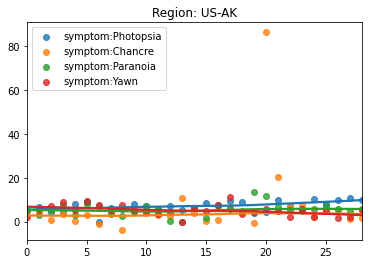

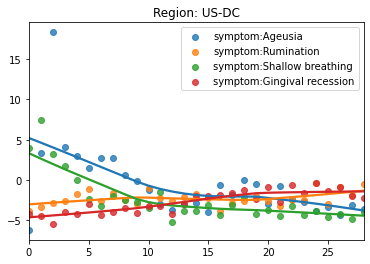

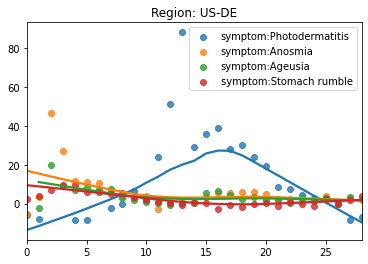

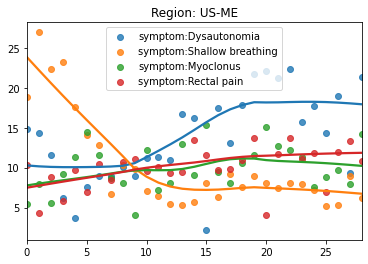

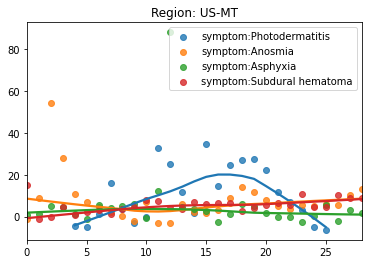

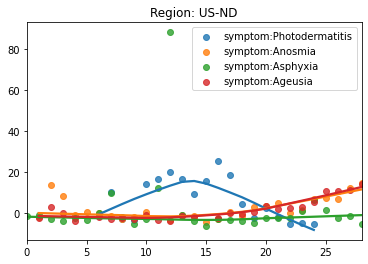

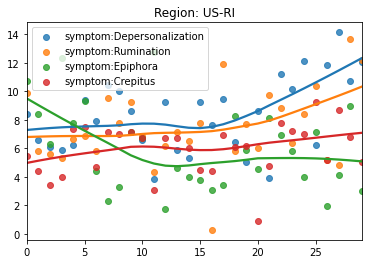

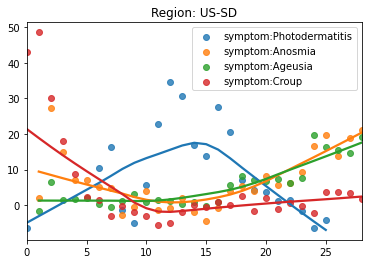

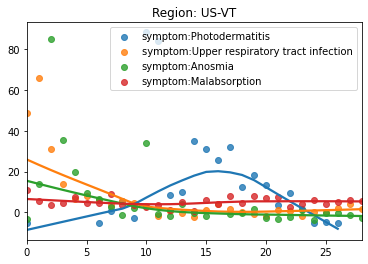

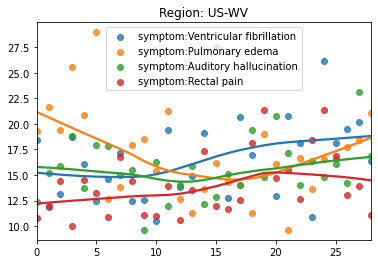

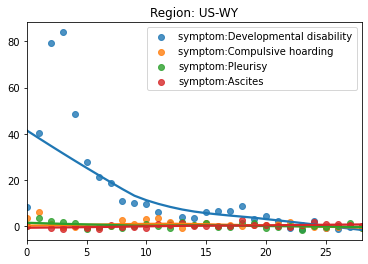

In [18]:
plot_data(only_symptoms_df,complete_df)

best number of clusters is:  8


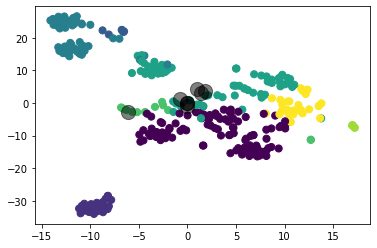

In [19]:
classify_KMeans(complete_df)

In [20]:
# knn_classifier(complete_df, 'region')

In [21]:
# knn_classifier(complete_df, 'time')

In [22]:
# decisionTree_regressor(complete_df, 'region')

In [23]:
# decisionTree_regressor(complete_df, 'time')

Minimum error:  -485.676272907122 at K = 49


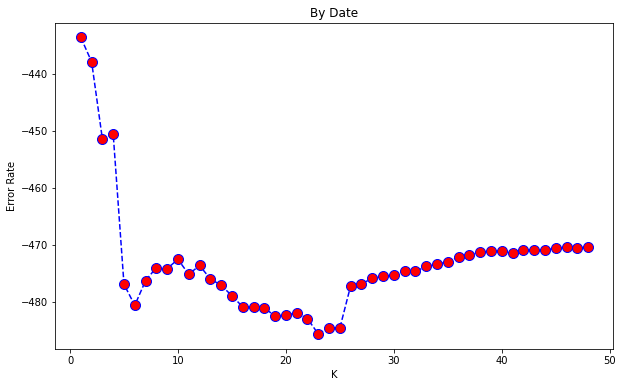

In [24]:
knn_classifier_correct(complete_df, 'region')

Minimum error:  -6367.859375 at K = 24


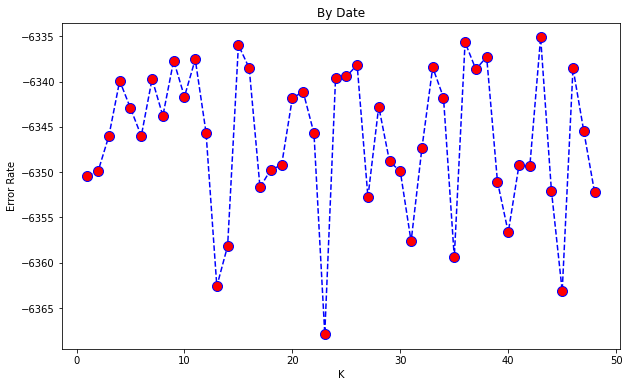

In [25]:
decisionTree_classifier_correct(complete_df, 'region')

Minimum error:  20.652849740932645 at K = 193


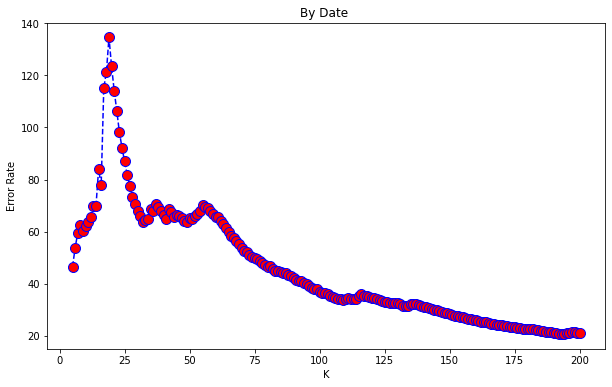

In [26]:
knn_classifier_correct(complete_df, 'time')

Minimum error:  135.99081802316036 at K = 1


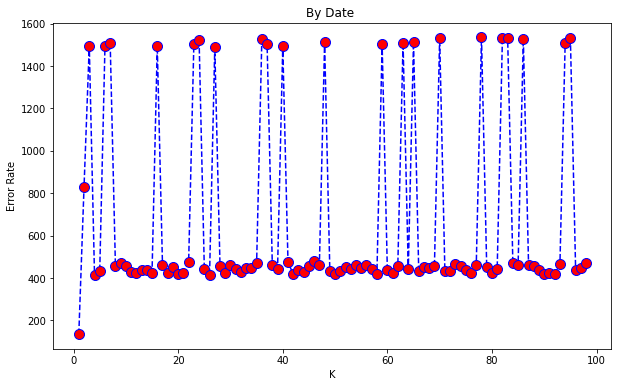

In [27]:
decisionTree_classifier_correct(complete_df, "time")